In [1]:
# Importing Libraries

In [2]:
import pandas as pd
import numpy as np

In [3]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

### Data

In [4]:
# Data directory
DATADIR = 'UCI_HAR_Dataset'

In [5]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [6]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [7]:

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()

In [8]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [1]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SUNNY\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [14]:
%tensorflow_version 1.x

UsageError: Line magic function `%tensorflow_version` not found.


In [9]:
#%tensorflow_version 1.x
import tensorflow as tf
tf.__version__

'1.15.0'

In [10]:
# Importing tensorflow
np.random.seed(42)
#import tensorflow as tf
tf.set_random_seed(42)

In [11]:
#tf.set_random_seed(
 #   seed
#)

In [12]:
# Configuring a session
session_conf = tf.ConfigProto(
                              intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1
                              )

In [13]:
#!pip install keras


In [14]:
# Import Keras
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


In [15]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

In [27]:
from keras.layers import LSTM , BatchNormalization
from keras.regularizers import L1L2

In [16]:
# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 32

In [17]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [18]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

C:\Users\SUNNY\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':
C:\Users\SUNNY\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


In [19]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


In [46]:
def plot_train_cv_loss(trained_model, epochs, colors=['g']):
    fig, ax = plt.subplots(1,1)    
    ax.set_xlabel('epoch') 
    ax.set_ylabel('Categorical Crossentropy Loss')
    x_axis_values = list(range(1,epochs+1))

    validation_loss = trained_model.history['val_loss']
    train_loss = trained_model.history['loss']   
    
    ax.plot(x_axis_values, validation_loss, 'g', label="Validation Loss")
    ax.plot(x_axis_values, train_loss, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

- Defining the Architecture of LSTM

In [91]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [22]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [23]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 92s 13ms/step - loss: 1.3018 - acc: 0.4395 - val_loss: 1.1254 - val_acc: 0.4662
Epoch 2/30
7352/7352 [==============================] - 94s 13ms/step - loss: 0.9666 - acc: 0.5880 - val_loss: 0.9491 - val_acc: 0.5714
Epoch 3/30
7352/7352 [==============================] - 97s 13ms/step - loss: 0.7812 - acc: 0.6408 - val_loss: 0.8286 - val_acc: 0.5850
Epoch 4/30
7352/7352 [==============================] - 95s 13ms/step - loss: 0.6941 - acc: 0.6574 - val_loss: 0.7297 - val_acc: 0.6128
Epoch 5/30
7352/7352 [==============================] - 92s 13ms/step - loss: 0.6336 - acc: 0.6912 - val_loss: 0.7359 - val_acc: 0.6787
Epoch 6/30
7352/7352 [==============================] - 94s 13ms/step - loss: 0.5859 - acc: 0.7134 - val_loss: 0.7015 - val_acc: 0.6939
Epoch 7/30
7352/7352 [==============================] - 95s 13ms/step - loss: 0.5692 - acc: 0.7477 - val_loss: 0.5995 - val_acc: 0.7387


In [24]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 512        0        25        0                   0   
SITTING                  3      410        75        0                   0   
STANDING                 0       87       445        0                   0   
WALKING                  0        0         0      481                   2   
WALKING_DOWNSTAIRS       0        0         0        0                 382   
WALKING_UPSTAIRS         0        0         0        2                  18   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                            3  
STANDING                           0  
WALKING                           13  
WALKING_DOWNSTAIRS                38  
WALKING_UPSTAIRS                 451  


In [27]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 4s 2ms/step


In [28]:
score

[0.3087582236972612, 0.9097387173396675]

- With a simple 2 layer architecture we got 90.09% accuracy and a loss of 0.30
- We can further imporve the performace with Hyperparameter tuning

## Trail 1

In [47]:
n_epochs = 30
n_batch = 16
n_classes = _count_classes(Y_train)

# Bias regularizer value - we will use elasticnet
reg = L1L2(0.01, 0.01)

In [54]:
model = Sequential()
model.add(LSTM(64, input_shape=(timesteps, input_dim), return_sequences=True, bias_regularizer=reg))
model.add(BatchNormalization())
model.add(Dropout(0.70))
model.add(LSTM(48))
model.add(Dropout(0.70))
model.add(Dense(n_classes, activation='sigmoid'))
print("Model Summary: ")
model.summary()

Model Summary: 
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 128, 64)           18944     
_________________________________________________________________
batch_normalization_5 (Batch (None, 128, 64)           256       
_________________________________________________________________
dropout_9 (Dropout)          (None, 128, 64)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 48)                21696     
_________________________________________________________________
dropout_10 (Dropout)         (None, 48)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 294       
Total params: 41,190
Trainable params: 41,062
Non-trainable params: 128
________________________________

In [31]:

model.compile(loss='categorical_crossentropy',
          optimizer='adam',
          metrics=['accuracy'])

In [ ]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import itertools
from datetime import datetime


In [36]:
start = datetime.now()

# Training the model
trained_model  = model.fit(X_train,
                           Y_train,
                           batch_size=n_batch,
                           validation_data=(X_test, Y_test),
                           epochs=n_epochs)

print("\n Time Taken: ",datetime.now() - start)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 77s 10ms/step - loss: 2.0127 - accuracy: 0.5732 - val_loss: 1.5402 - val_accuracy: 0.5599
Epoch 2/30
7352/7352 [==============================] - 73s 10ms/step - loss: 1.1514 - accuracy: 0.6786 - val_loss: 0.8725 - val_accuracy: 0.7180
Epoch 3/30
7352/7352 [==============================] - 72s 10ms/step - loss: 0.7743 - accuracy: 0.7205 - val_loss: 0.6062 - val_accuracy: 0.7984
Epoch 4/30
7352/7352 [==============================] - 72s 10ms/step - loss: 0.5762 - accuracy: 0.7930 - val_loss: 0.6264 - val_accuracy: 0.7631
Epoch 5/30
7352/7352 [==============================] - 73s 10ms/step - loss: 0.4387 - accuracy: 0.8607 - val_loss: 0.2864 - val_accuracy: 0.9080
Epoch 6/30
7352/7352 [==============================] - 72s 10ms/step - loss: 0.3510 - accuracy: 0.8879 - val_loss: 0.2474 - va

In [38]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = 'DejaVu Sans'
import seaborn as sns

# To be able to save images on server
import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot


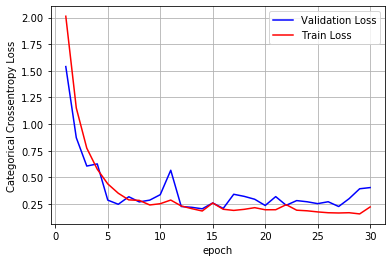

In [39]:
plot_train_cv_loss(trained_model, n_epochs)

In [43]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 537        0         0        0                   0   
SITTING                  0      319       151        0                   0   
STANDING                 0       44       487        0                   0   
WALKING                  0        0         0      485                   6   
WALKING_DOWNSTAIRS       0        0         0       12                 376   
WALKING_UPSTAIRS         0        7         1       28                   8   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                           21  
STANDING                           1  
WALKING                            5  
WALKING_DOWNSTAIRS                32  
WALKING_UPSTAIRS                 427  


In [44]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 5s 2ms/step


In [45]:
score

[0.4040787009415503, 0.8927723169326782]

In [1]:
#here i have build a 2 LSTM layes, 1 batch normalization and  dense layer  with adms optiiser and sigmoid activation
#the artitechure is 4 layers and it performed well 
#the performance of the model is 89.27 
#now lets try another model

## Trail 2

In [86]:
n_epochs = 16
n_batch = 16
n_classes = _count_classes(Y_train)


In [87]:
model2 = Sequential()
model2.add(LSTM(64, input_shape=(timesteps, input_dim),))
model2.add(Dropout(0.5))
model2.add(Dense(n_classes, activation='softmax'))
print("Model Summary: ")
model2.summary()

Model Summary: 
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 64)                18944     
_________________________________________________________________
dropout_16 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 6)                 390       
Total params: 19,334
Trainable params: 19,334
Non-trainable params: 0
_________________________________________________________________


In [89]:
model2.compile(loss='binary_crossentropy',
          optimizer='Nadam',
          metrics=['accuracy'])

In [90]:

start = datetime.now()

# Training the model
trained_model  = model2.fit(X_train,
                           Y_train,
                           batch_size=n_batch,
                           validation_data=(X_test, Y_test),
                           epochs=n_epochs)

print("\n Time Taken: ",datetime.now() - start)

Train on 7352 samples, validate on 2947 samples
Epoch 1/16
7352/7352 [==============================] - 42s 6ms/step - loss: 0.2817 - accuracy: 0.8803 - val_loss: 0.3240 - val_accuracy: 0.8506
Epoch 2/16
7352/7352 [==============================] - 38s 5ms/step - loss: 0.2606 - accuracy: 0.8863 - val_loss: 0.2132 - val_accuracy: 0.8986
Epoch 3/16
7352/7352 [==============================] - 40s 5ms/step - loss: 0.1796 - accuracy: 0.9222 - val_loss: 0.1636 - val_accuracy: 0.9384
Epoch 4/16
7352/7352 [==============================] - 39s 5ms/step - loss: 0.1627 - accuracy: 0.9361 - val_loss: 0.1660 - val_accuracy: 0.9303
Epoch 5/16
7352/7352 [==============================] - 38s 5ms/step - loss: 0.1162 - accuracy: 0.9580 - val_loss: 0.1120 - val_accuracy: 0.9541
Epoch 6/16
7352/7352 [==============================] - 38s 5ms/step - loss: 0.0924 - accuracy: 0.9682 - val_loss: 0.2662 - val_accuracy: 0.9009
Epoch 7/16
7352/7352 [==============================] - 36s 5ms/step - loss: 0.102

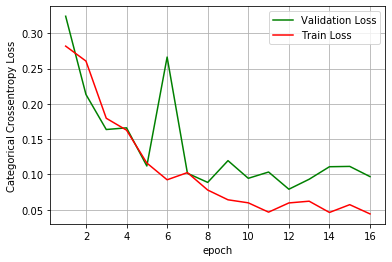

In [91]:
plot_train_cv_loss(trained_model, n_epochs)

In [92]:
# Confusion Matrix
print(confusion_matrix(Y_test, model2.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 537        0         0        0                   0   
SITTING                  0      301       190        0                   0   
STANDING                 0       37       494        0                   0   
WALKING                  0        0         0      474                  15   
WALKING_DOWNSTAIRS       0        0         0        8                 379   
WALKING_UPSTAIRS         0        0         1       14                   0   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                            0  
STANDING                           1  
WALKING                            7  
WALKING_DOWNSTAIRS                33  
WALKING_UPSTAIRS                 456  


In [93]:
score = model2.evaluate(X_test, Y_test)

2947/2947 [==============================] - 2s 721us/step


In [94]:
score

[0.09692795821130665, 0.9655581116676331]

In [2]:
# now lets try the same 2layerd artictechure with different optimizer
#now i had taken the LSTM layey with 64 neurons with softmax activation and nadan optimiser the models works very well
#it has given the results of 96.55 accuracy of the test 

## Trail 3

In [95]:
n_epochs = 13
n_batch = 16
n_classes = _count_classes(Y_train)


In [97]:
model3 = Sequential()
model3.add(LSTM(64,input_shape=(timesteps, input_dim),return_sequences=True))
model3.add(Dropout(0.7))
model3.add(LSTM(32))
model3.add(Dropout(0.7))
model3.add(Dense(n_classes, activation='softmax'))
print("Model Summary: ")
model3.summary()

Model Summary: 
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 128, 64)           18944     
_________________________________________________________________
dropout_17 (Dropout)         (None, 128, 64)           0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dropout_18 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 6)                 198       
Total params: 31,558
Trainable params: 31,558
Non-trainable params: 0
_________________________________________________________________


In [98]:
model3.compile(loss='binary_crossentropy',
          optimizer='Adam',
          metrics=['accuracy'])

In [99]:

start = datetime.now()

# Training the model
trained_model  = model3.fit(X_train,
                           Y_train,
                           batch_size=n_batch,
                           validation_data=(X_test, Y_test),
                           epochs=n_epochs)

print("\n Time Taken: ",datetime.now() - start)

Train on 7352 samples, validate on 2947 samples
Epoch 1/13
7352/7352 [==============================] - 72s 10ms/step - loss: 0.3091 - accuracy: 0.8756 - val_loss: 0.2432 - val_accuracy: 0.8895
Epoch 2/13
7352/7352 [==============================] - 72s 10ms/step - loss: 0.2118 - accuracy: 0.9122 - val_loss: 0.2528 - val_accuracy: 0.8897
Epoch 3/13
7352/7352 [==============================] - 67s 9ms/step - loss: 0.1890 - accuracy: 0.9225 - val_loss: 0.2276 - val_accuracy: 0.9047
Epoch 4/13
7352/7352 [==============================] - 66s 9ms/step - loss: 0.1461 - accuracy: 0.9458 - val_loss: 0.1245 - val_accuracy: 0.9582
Epoch 5/13
7352/7352 [==============================] - 66s 9ms/step - loss: 0.1337 - accuracy: 0.9536 - val_loss: 0.1282 - val_accuracy: 0.9549
Epoch 6/13
7352/7352 [==============================] - 68s 9ms/step - loss: 0.1132 - accuracy: 0.9623 - val_loss: 0.0878 - val_accuracy: 0.9659
Epoch 7/13
7352/7352 [==============================] - 68s 9ms/step - loss: 0.1

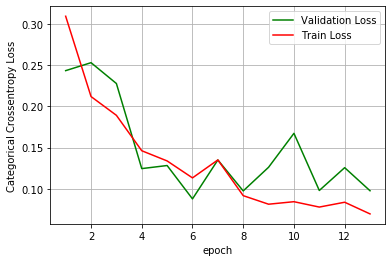

In [100]:
plot_train_cv_loss(trained_model, n_epochs)

In [101]:
# Confusion Matrix
print(confusion_matrix(Y_test, model3.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 537        0         0        0                   0   
SITTING                  0      365       116        0                   0   
STANDING                 0       61       470        1                   0   
WALKING                  1        0         1      440                   7   
WALKING_DOWNSTAIRS       0        0         0        0                 409   
WALKING_UPSTAIRS         3        0         0       12                   0   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                           10  
STANDING                           0  
WALKING                           47  
WALKING_DOWNSTAIRS                11  
WALKING_UPSTAIRS                 456  


In [102]:
score = model3.evaluate(X_test, Y_test)

2947/2947 [==============================] - 4s 1ms/step


In [103]:
score

[0.09760692525769749, 0.9694604873657227]

In [3]:
## now lets again develop the tarial 1 artitechure 
#let us now consider the 2 lstm layes and optimiser as "adams" and activation as the "softmax"
#here i am using the gereater dropout factor becouse we are dealing with the less data and grreater artitecure 
#this model worked pretty well than the trail 2 model by 0.39

In [4]:
#i have tried the diffent optimiser like relu with different actiation n the different notebook 

# Conclusion 

In [5]:
## from the two notebooks the observed results are 

In [6]:
## pretty table

In [8]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable


x = PrettyTable()
x.field_names = ["Model", "No of layers","Optimizer", "Activation ","Multiclass log loss ","Accuracy"]

x.add_row(['LSTM' , 1 ,  "rmsprop" ,"sigmoid"  , 0.3087 , 90.97 ])
x.add_row(["LSTM" , 1 ,  "adagrad" ,"sigmoid"  , 0.7983 , 60.909 ])
x.add_row(['LSTM' , 1 ,  "Nadam"   ,"softmax " , 0.096  , 96.55])
x.add_row(["LSTM" , 2 ,  "adam"    ,"softmax"  , 0.097  , 96.946 ])
x.add_row(["LSTM" , 2 ,  "adam"    , "sigmoid" , 0.4040 , 89.277])
x.add_row(["LSTM" , 2 ,  "adam"    ,"sigmoid"  , 0.3027 , 91.652 ])
x.add_row(["LSTM" , 2 ,  "adam"    ,"relu"     , "-"    , 16.8 ])


print(x)

+-------+--------------+-----------+-------------+----------------------+----------+
| Model | No of layers | Optimizer | Activation  | Multiclass log loss  | Accuracy |
+-------+--------------+-----------+-------------+----------------------+----------+
|  LSTM |      1       |  rmsprop  |   sigmoid   |        0.3087        |  90.97   |
|  LSTM |      1       |  adagrad  |   sigmoid   |        0.7983        |  60.909  |
|  LSTM |      1       |   Nadam   |   softmax   |        0.096         |  96.55   |
|  LSTM |      2       |    adam   |   softmax   |        0.097         |  96.946  |
|  LSTM |      2       |    adam   |   sigmoid   |        0.404         |  89.277  |
|  LSTM |      2       |    adam   |   sigmoid   |        0.3027        |  91.652  |
|  LSTM |      2       |    adam   |     relu    |          -           |   16.8   |
+-------+--------------+-----------+-------------+----------------------+----------+
